In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Loading dataset available at:

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [2]:
# Loading data
dataset = pd.read_csv('../dataset/household_power_consumption.txt', delimiter = ';', low_memory = False)
print("Data Shape: " + str(dataset.shape))
dataset.head()

Data Shape: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
dataset_sample = dataset.sample(2000)
dataset_sample.shape

(2000, 9)

### Checking and treating NA values

In [4]:
# Checking NA values for each column
dataset_sample.isna().sum()

Date                      0
Time                      0
Global_active_power       0
Global_reactive_power     0
Voltage                   0
Global_intensity          0
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3           23
dtype: int64

#### According to the dataset description, Sub_metereing_3 "corresponds to an electric water-heater and an air-conditioner." 
#### NA values probably mean that the house is not equiped with this items. Thus, we will replace it by zeros
#### We will also delete the Data and Time columns, since they are not valid for our purpose

In [5]:
dataset_sample_2 = dataset_sample.fillna(0).drop(["Date", "Time"],axis=1)
dataset_sample_2.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Several fiels are placed with '?', which will be removed from the dataset

In [6]:
count = 0
for i in dataset_sample_2:
    for j in dataset_sample_2[i]:
        if j == '?': count += 1
print("'?' fields: " + str(count))        

'?' fields: 138


In [7]:
rows = [x if "?" in dataset_sample_2.iloc[[x]].values else "Null" for x in range(len(dataset_sample_2))]
rows = [x for x in rows if x != "Null"]

In [8]:
dataset_sample_3 = dataset_sample_2.drop(dataset_sample_2.index[rows], 0)
count = 0
for i in dataset_sample_3:
    for j in dataset_sample_3[i]:
        if j == '?': count += 1
print("'?' fields: " + str(count))        

'?' fields: 0


### Scaling data

In [9]:
X = scale(dataset_sample_3)

### Finding best number K of clusters 

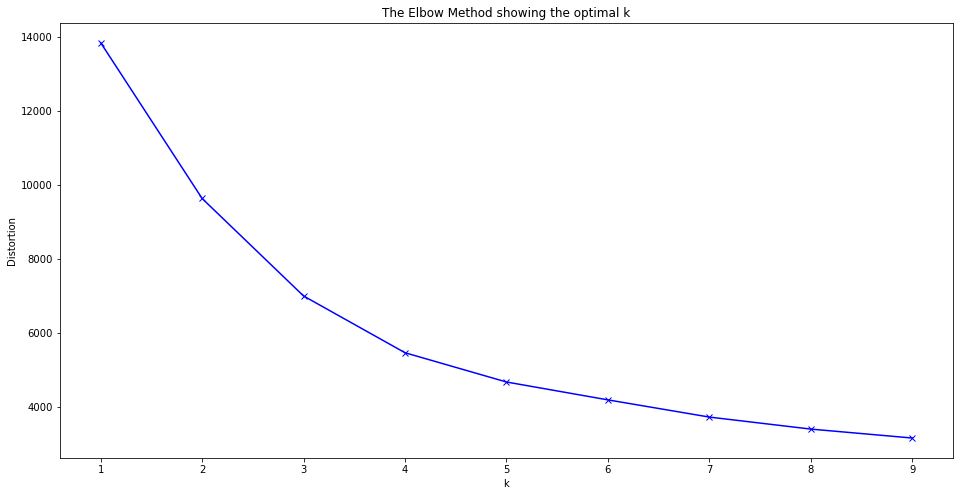

In [10]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### According to the Elbow Method, we will choose K = 5

### Creating the Model

In [11]:
K = 4
kmeans = KMeans(n_clusters = K).fit(X)
labels = kmeans.labels_

### Creating Meschgrid by dimension reduction with PCA

In [12]:
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
centers = pca.transform(kmeans.cluster_centers_)

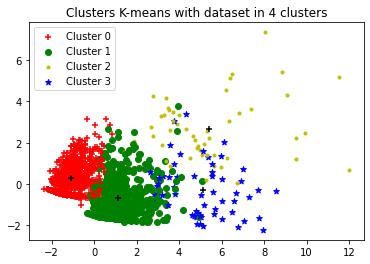

In [13]:
for i in range(0, pca_2d.shape[0]):
    if labels[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1], c ='r', marker = '+')
        
    elif labels[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1], c ='g', marker = 'o')
        
    elif labels[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1], c ='y', marker = '.')

    elif labels[i] == 3:
        c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1], c ='b', marker = '*')

pl.scatter(centers[:,0], centers[:,1], c = "black", marker = "+")
        
pl.legend([c1, c2, c3, c4],['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
pl.title('Clusters K-means with dataset in 4 clusters')
pl.show()

### Calculating the silhouete score

In [14]:
silhouette_value = silhouette_score(X, labels)
silhouette_value

0.4290635859447211

### Calculating the mean consumption per cluster

In [15]:
data = dataset_sample_3.astype(float)

In [16]:
data["labels"] = labels

In [17]:
for i in range(K):
    print("The mean consunption of cluster " + str(i) + " is: " + str(data[data["labels"] == i]["Global_active_power"].mean()))

The mean consunption of cluster 0 is: 0.4546288573811504
The mean consunption of cluster 1 is: 1.8238658718330838
The mean consunption of cluster 2 is: 4.06484
The mean consunption of cluster 3 is: 3.8568771929824557
